# 1 Author

**Student Name**:  Jingyu Huang
**Student ID**:  2021212797


In [27]:
import os,argparse
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torchvision
import cv2 as cv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import math
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix

# 2 Problem formulation
在这个问题中，我们要解决图片中人脸头部预测的问题，要求输入一张图片，输出三个维度的预测结果
感兴趣的地方：1.这本质上是一个regression problem，如何设计pipline 能使我们的模型达到最好的性能
2.运用什么样的模型能实现这个预测
3.我们应该怎样衡量输出结果的好坏，模型的性能，regression problem 的输出是线性的，无法做判断计算准确性

# 3 Machine Learning pipeline

image  ---> dlib  --->  transformation  --->  model  --->  output

dlib:
输入：（image_width, image_hight, 3）
输出：（cropped_image_width,cropped_image_hight,3）


Transformation：
输入：（cropped_image_width,cropped_image_hight,3）
输出：（3，224，224）

model：
输入：（3，224，224）
输出：（3，66）


# 4 Transformation stage

1.用dlib 检测人脸并进行裁剪---> 输出RGB形式的图片 （cropped_image_width,cropped_image_hight，3）
2.将图片的维度压缩成（256，256）大小的图片 ---> 输出一张（256，256，3）大小的图片
3.将图片随机裁剪成（244，244）大小的图片 ---> 输出一张（244，244，3）大小的图片
4.将图片tensor 化，输出的维度会发生变化   ---> 输出（3，244，244）大小的tensor
5.对tensor进行标准化处理  ---> 输出（3，244，244）大小的tensor


In [28]:
# Hyperparameters
pictures_width = 224
pictures_hight = 224
sample_num=4000
num_epochs = 1
train_batch_size = 16
learning_rate= 0.0001
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
image_size = 224

data_transforms = {
            'train': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(244),
                transforms.CenterCrop([image_size,image_size]),
                transforms.ToTensor(),
                transforms.Normalize(normalize_mean, normalize_std)
            ]),
            'val': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(256),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(normalize_mean, normalize_std)
            ])
                }

# 5 Modelling

这次我参考了论文Fine-Grained Head Pose Estimation Without Keypoints，采用了Hopenet，它的框架先是一个resnet，输出（512，1，1）维度的tensor，这个输出进入三个不同的全连接神经网络，每一个输出都是（66，1），这个输出表示的是，我们将弧度制角度量化，变成66个点，每一个维度的值对应再这个角度的概率。因为在笑脸分类的任务中，我已经阐述过resnet模型的结构了，所以这里我会省略resnet每一层的输入和输出，只保留resnet整体的输入和输出：

输入：（3，224，224）
进入resnet，输出：（512，1）
输出同时进入三个不同全连接神经网络，每一个网络输出：（66，1）




In [29]:
class Hopenet(nn.Module):
    # Hopenet with 3 output layers for yaw, pitch and roll
    # Predicts Euler angles by binning and regression with the expected value
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(Hopenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll

# 6 Methodology
参考论文中的思路，为了使得模型有更好的性能，可以将regression question 又变成分类问题，方法就是将角度量化在66个值中，当作模型的输出的grandtruth。最精妙的地方是我们的损失函数，我将模型66维度的输出当作是每一个角度的概率分布，这样就能计算预测角度的期望，得到一个continuous value，再将这个value与数据集原本的label做MSE，再加上模型与离散化的label计算出的交叉熵，两部分的和才是模型的loss function。通过这个方法，很巧妙得将regression question 与 分类问题结合起来，在论文的验证中得到了很好的performance。而在评估性能方面，我们可以采用confusion matrix 来评估。

In [30]:
def get_ignored_params(model):
    # Generator function that yields ignored params.
    b = [model.conv1, model.bn1, model.fc_finetune]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_non_ignored_params(model):
    # Generator function that yields params that will be optimized.
    b = [model.layer1, model.layer2, model.layer3, model.layer4]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_fc_params(model):
    # Generator function that yields fc layer params.
    b = [model.fc_yaw, model.fc_pitch, model.fc_roll]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            for name, param in module.named_parameters():
                yield param

def plot_confusion_matrix(cm, labels_name, title):
    plt.cla()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

In [31]:
def model_train(model,train_loader,val_loader):
   
    train_epochs_loss = []
    val_epochs_loss = []
    model = model.cuda()
    softmax = nn.Softmax().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    reg_criterion = nn.MSELoss().cuda()
    # Regression loss coefficient
    alpha = 0.001
    lr = 0.001
    best_loss = 10
    patience = 5

    idx_tensor = [idx for idx in range(66)]
    idx_tensor = Variable(torch.FloatTensor(idx_tensor)).cuda()

    optimizer = torch.optim.Adam([{'params': get_ignored_params(model), 'lr': 0},
                                    {'params': get_non_ignored_params(model), 'lr': lr},
                                    {'params': get_fc_params(model), 'lr': lr * 5}],
                                    lr = lr)


    for epoch in range(num_epochs):
        train_epoch_loss = []
        val_epoch_loss = []
        for i, (images, labels, cont_labels) in enumerate(train_loader):
            images = Variable(images).cuda()

            # Binned labels
            label_yaw = Variable(labels[:,0]).cuda()
            label_pitch = Variable(labels[:,1]).cuda()
            label_roll = Variable(labels[:,2]).cuda()

            # print(label_yaw)
            # print(label_pitch)
            # print(label_roll)

            # Continuous labels
            label_yaw_cont = Variable(cont_labels[:,0]).cuda()
            label_pitch_cont = Variable(cont_labels[:,1]).cuda()
            label_roll_cont = Variable(cont_labels[:,2]).cuda()

            # Forward pass
            yaw, pitch, roll = model(images)

            # Cross entropy loss
            loss_yaw = criterion(yaw, label_yaw)
            loss_pitch = criterion(pitch, label_pitch)
            loss_roll = criterion(roll, label_roll)

            # MSE loss
            yaw_predicted = softmax(yaw)
            pitch_predicted = softmax(pitch)
            roll_predicted = softmax(roll)

            yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1) * 3 - 99
            pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1) * 3 - 99
            roll_predicted = torch.sum(roll_predicted * idx_tensor, 1) * 3 - 99

            loss_reg_yaw = reg_criterion(yaw_predicted, label_yaw_cont)
            loss_reg_pitch = reg_criterion(pitch_predicted, label_pitch_cont)
            loss_reg_roll = reg_criterion(roll_predicted, label_roll_cont)

            # Total loss
            loss_yaw += alpha * loss_reg_yaw
            loss_pitch += alpha * loss_reg_pitch
            loss_roll += alpha * loss_reg_roll

            loss_seq = [loss_yaw, loss_pitch, loss_roll]
            optimizer.zero_grad()
            loss_total = loss_yaw + loss_pitch + loss_roll
            
            loss_total.backward()
            optimizer.step()
            train_epoch_loss.append(loss_total.item())

            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Iter [%d/%d] Losses: Yaw %.4f, Pitch %.4f, Roll %.4f'
                        %(epoch+1, num_epochs, i+1, int(sample_num*0.8)//train_batch_size, loss_yaw.item(), loss_pitch.item(), loss_roll.item()))
        train_epochs_loss.append(np.average(train_epoch_loss))
        torch.save(model.state_dict(),"models/pose_detect_last.pth")
        with torch.no_grad():
            model.eval()
            for i, (images, labels, cont_labels) in enumerate(val_loader):
                images = Variable(images).cuda()

                # Binned labels
                label_yaw = Variable(labels[:,0]).cuda()
                label_pitch = Variable(labels[:,1]).cuda()
                label_roll = Variable(labels[:,2]).cuda()

                # print(label_yaw)
                # print(label_pitch)
                # print(label_roll)

                # Continuous labels
                label_yaw_cont = Variable(cont_labels[:,0]).cuda()
                label_pitch_cont = Variable(cont_labels[:,1]).cuda()
                label_roll_cont = Variable(cont_labels[:,2]).cuda()

                # Forward pass
                yaw, pitch, roll = model(images)

                # Cross entropy loss
                loss_yaw = criterion(yaw, label_yaw)
                loss_pitch = criterion(pitch, label_pitch)
                loss_roll = criterion(roll, label_roll)

                # MSE loss
                yaw_predicted = softmax(yaw)
                pitch_predicted = softmax(pitch)
                roll_predicted = softmax(roll)

                yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1) * 3 - 99
                pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1) * 3 - 99
                roll_predicted = torch.sum(roll_predicted * idx_tensor, 1) * 3 - 99

                loss_reg_yaw = reg_criterion(yaw_predicted, label_yaw_cont)
                loss_reg_pitch = reg_criterion(pitch_predicted, label_pitch_cont)
                loss_reg_roll = reg_criterion(roll_predicted, label_roll_cont)

                # Total loss
                loss_yaw += alpha * loss_reg_yaw
                loss_pitch += alpha * loss_reg_pitch
                loss_roll += alpha * loss_reg_roll

                loss_total = loss_yaw + loss_pitch + loss_roll
                

                val_epoch_loss.append(loss_total.item())
            val_loss = np.average(val_epoch_loss)
            val_epochs_loss.append(np.average(val_epoch_loss))
            print ('Epoch [%d/%d], val Losses:  %.4f'
                        %(epoch+1, num_epochs, val_loss))
            if val_loss<best_loss:
                counter = 0
                best_loss = val_loss
                torch.save(model.state_dict(),"models/pose_detect_best.pth")
            else:
                counter +=1
            if counter>=patience:
                print("Earlystop")
                break
    print("Training complete!")
    plt.figure(figsize=(12, 4))
    plt.plot(train_epochs_loss, '-o', label="train_loss")
    plt.plot(val_epochs_loss, '-o', label="valid_loss")
    plt.title("epochs_loss")
    plt.show()


def model_test(model,test_loader):
       
    pre_yaw=[]
    true_yaw=[]

    pre_pitch=[]
    true_pitch=[]

    pre_roll=[]
    true_roll=[]

    acc1,nums1 = 0,0
    acc2,nums2 = 0,0
    acc3,nums3 = 0,0
    model = model.cuda()
    softmax = nn.Softmax().cuda()
    # Regression loss coefficient
    alpha = 0.001
    lr = 0.001

    idx_tensor = [idx for idx in range(66)]
    idx_tensor = Variable(torch.FloatTensor(idx_tensor)).cuda()
    with torch.no_grad():
        model.eval()

        for i, (images, labels, cont_labels) in enumerate(test_loader):
            images = Variable(images).cuda()

            # Binned labels
            label_yaw = Variable(labels[:,0]).cuda()
            label_pitch = Variable(labels[:,1]).cuda()
            label_roll = Variable(labels[:,2]).cuda()
            # print(label_yaw)
            # print(label_pitch)
            # print(label_roll)
            

            # Forward pass
            yaw, pitch, roll = model(images)

            acc1 += sum(yaw.max(axis=1)[1] == label_yaw)
            pre_yaw.append(yaw.max(axis=1)[1].item())
            true_yaw.append(label_yaw.item())

            acc2 += sum(pitch.max(axis=1)[1] == label_pitch)
            pre_pitch.append(pitch.max(axis=1)[1].item())
            true_pitch.append(label_pitch.item())

            acc3 += sum(pitch.max(axis=1)[1] == label_roll)
            pre_roll.append(roll.max(axis=1)[1].item())
            true_roll.append(label_roll.item())

            nums1 += labels.size()[0]
            nums2 += labels.size()[0]
            nums3 += labels.size()[0]

        print("test acc = {:.3}%".format(100 * acc1 / nums1))
        print("test acc = {:.3}%".format(100 * acc2 / nums2))
        print("test acc = {:.3}%".format(100 * acc3 / nums3))

        # print(pre_yaw)
        # print(true_yaw)

        # print(pre_pitch)
        # print(true_pitch)

        # print(pre_roll)
        # print(true_roll)

        a =  confusion_matrix(pre_yaw, true_yaw,labels=range(0,66))
        b =  confusion_matrix(pre_pitch, true_pitch,labels=range(0,66))
        c =  confusion_matrix(pre_roll, true_roll,labels=range(0,66))
        
        return a,b,c


# 7 Dataset
根据数据集的储存格式，我们可以用一个列表按顺序储存图片的地址以及对应的label。
然后我创建了一个（0，4000）的序列数组，并将它乱序，这个操作是为了打乱数据集。
取（0，3200）的序列为train_sample。
采用torch.utils.data中的dataset方法，生成我的数据集，x_data是图片地址，y_data是四维度的label，在dataset方法中，会先通过cv.read读取出图片，在进行transform，transform操作是我们在前面定义过的，然后我们还要对label 做digitalization，将每一个pose的label从一个一维的数值变成（66，1）的tensor，tensor中只有一个元素为1，其余为0。
而dataset的输出是图片，离散角度，连续角度三个值。
可以看到dataloader的输出，x_data都是（3，224，224）维度，label是（66，1）维度，con_label是（1）维度


In [32]:
# transform 处理
# 读取图片 ，并将图片的寸尺调整至一样，这样才能进行训练
# 有很多方法实现维度一致，可以padding，可以crop，可以直接resize
# up to you to design
pictures_path=['crop_img/file{}.jpg'.format(str(i).zfill(4)) for i in range(1,4001)]
label_data = np.genfromtxt("genki4k/labels.txt") 
index_list =np.arange(0,4000)
np.random.shuffle(index_list)
shuffle_path =[]
shuffle_lable = np.zeros((4000,4))
j=0
for i in index_list:
    shuffle_path.append(pictures_path[i])
    shuffle_lable[j] = label_data[i]
    j+=1

class poseDataset(Dataset):
    def __init__(self,x_data,y_data,transforms):
        self.x_data=x_data
        self.transforms = transforms
        self.y_data=torch.from_numpy(y_data[:,1:])
        self.len=len(x_data)
    def __getitem__(self,index):
        img = cv.imread(self.x_data[index])
        pitch = self.y_data[index,0]*180 /np.pi
        yaw = self.y_data[index,1]*180 /np.pi
        roll = self.y_data[index,2]*180 /np.pi
        bins = np.array(range(-99,102,3))
        binned_pose = np.digitize([yaw,pitch,roll],bins)-1

        labels = binned_pose
        cont_labels = torch.FloatTensor([yaw,pitch,roll])

        if self.transforms is not None:
            img = self.transforms(img)

        return img,labels ,cont_labels 
    def __len__(self):
        return self.len
    
#定义dataloader，装载数据给模型

train_dataset=poseDataset(x_data=shuffle_path[0:3200],y_data=shuffle_lable[0:3200] , transforms=data_transforms['train'])
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_batch_size,
                          shuffle=True)
val_dataset=poseDataset(x_data=shuffle_path[3200:3600],y_data=shuffle_lable[3200:3600],transforms=data_transforms['val'])
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=32,
                          shuffle=True)
test_dataset=poseDataset(x_data=shuffle_path[3600:4000],y_data=shuffle_lable[3600:4000],transforms=data_transforms['val'])
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          shuffle=True)

In [ ]:
for i in range(0,10):
    img = cv.imread(pictures_path[i])
    plt.imshow(img)
    plt.title('img')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


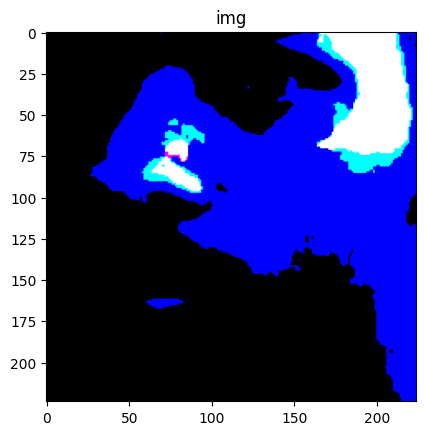

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


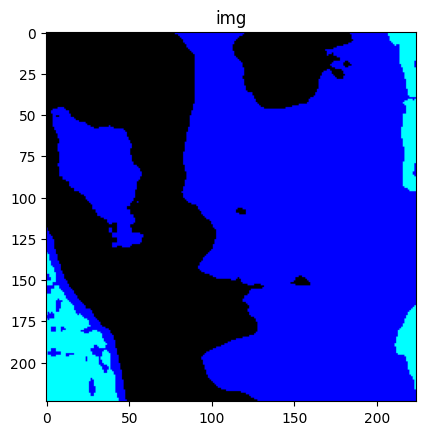

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


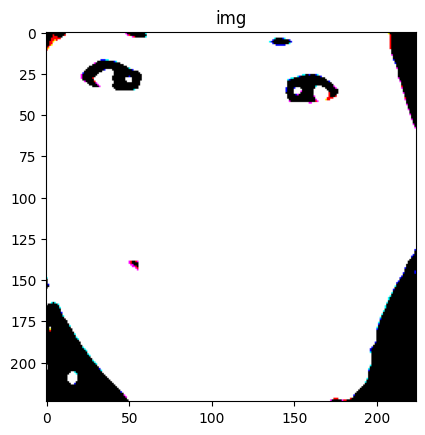

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


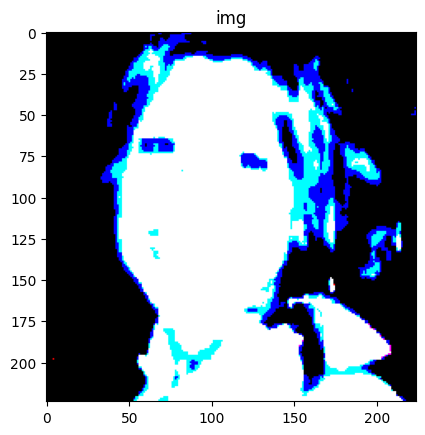

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


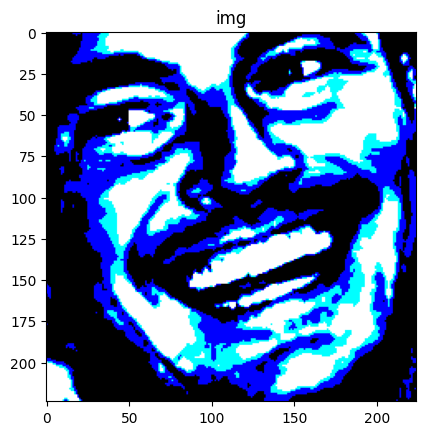

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


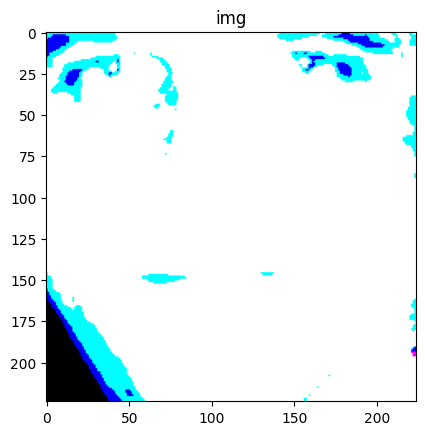

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


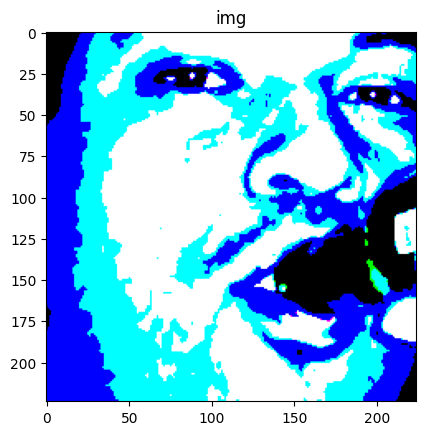

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


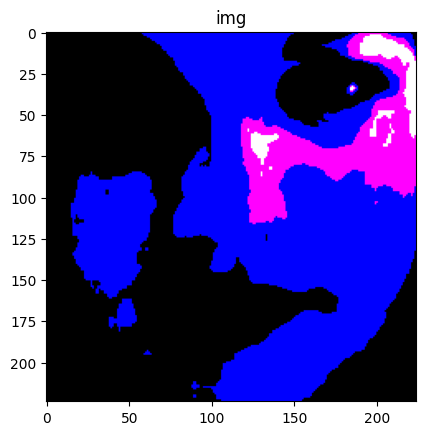

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


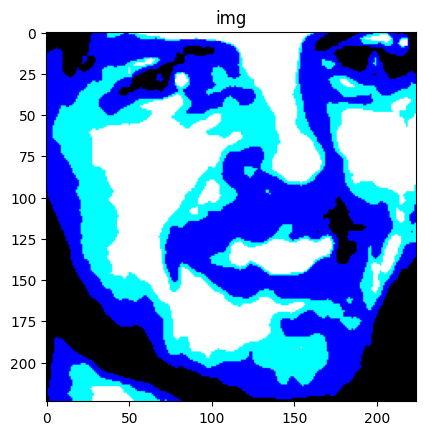

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


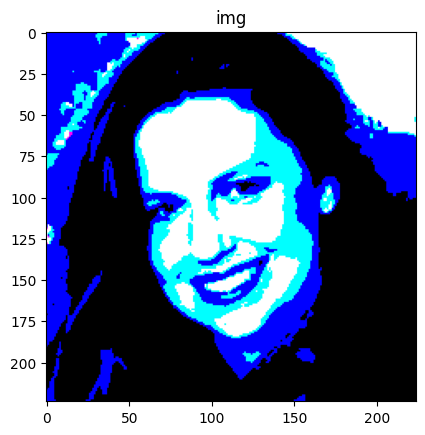

In [34]:
for i, (img,label,con_label) in enumerate(train_loader):
    for j in range (0,10):
        img_t = img[j]
        # img_t=img_t.view(224,224,3)
        # img_t =img_t.numpy()

        ndarr = img_t.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
        print(ndarr.shape)
        plt.imshow(ndarr)
        plt.title('img')
        plt.show()
    break

# 8 Results
通过confusion matrix，可以看到，对角线上的方块是最深的，说明数值是最大的，基本呈现从对角线扩散开来的趋势，说明模型有一定预测效果不错，注意到，confusion matrix 呈现一条直线，那是因为数据集中的pose 基本上在一个很小的角度范围内，所以导致label 中没有其它角度的值,生成的confusion matrix 是一个很窄的线。

In [17]:
model = Hopenet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)
model_train(model,train_loader,val_loader)
a,b,c=model_test(model,test_loader)
a = a[30:40,30:40]
b = b[30:40,30:40]
c = c[30:40,30:40]

d:\anaconda\envs\dlib\lib\site-packages\torch\_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)
d:\anaconda\envs\dlib\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/10], Iter [100/200] Losses: Yaw 2.4511, Pitch 3.0711, Roll 2.2854
Epoch [1/10], Iter [200/200] Losses: Yaw 2.1937, Pitch 2.7835, Roll 2.2790
Epoch [2/10], Iter [100/200] Losses: Yaw 2.0996, Pitch 2.6671, Roll 2.2530
Epoch [2/10], Iter [200/200] Losses: Yaw 2.3695, Pitch 2.7100, Roll 2.3178
Epoch [3/10], Iter [100/200] Losses: Yaw 1.9643, Pitch 2.5776, Roll 2.4129
Epoch [3/10], Iter [200/200] Losses: Yaw 2.6453, Pitch 2.9813, Roll 2.8181


KeyboardInterrupt: 

In [18]:
a,b,c=model_test(model,test_loader)
a = a[30:40,30:40]
b = b[30:40,30:40]
c = c[30:40,30:40]

tensor([31], device='cuda:0')
tensor([37], device='cuda:0')
tensor([34], device='cuda:0')
tensor([31], device='cuda:0')
tensor([37], device='cuda:0')
tensor([34], device='cuda:0')
tensor([32], device='cuda:0')
tensor([30], device='cuda:0')
tensor([32], device='cuda:0')
tensor([32], device='cuda:0')
tensor([30], device='cuda:0')
tensor([32], device='cuda:0')
tensor([36], device='cuda:0')
tensor([33], device='cuda:0')
tensor([31], device='cuda:0')
tensor([36], device='cuda:0')
tensor([33], device='cuda:0')
tensor([31], device='cuda:0')
tensor([31], device='cuda:0')
tensor([42], device='cuda:0')
tensor([30], device='cuda:0')
tensor([31], device='cuda:0')
tensor([42], device='cuda:0')
tensor([30], device='cuda:0')
tensor([29], device='cuda:0')
tensor([34], device='cuda:0')
tensor([29], device='cuda:0')
tensor([29], device='cuda:0')
tensor([34], device='cuda:0')
tensor([29], device='cuda:0')
tensor([33], device='cuda:0')
tensor([31], device='cuda:0')
tensor([30], device='cuda:0')
tensor([33

C:\Users\Martin\AppData\Local\Temp\ipykernel_4568\1899464866.py:31: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化


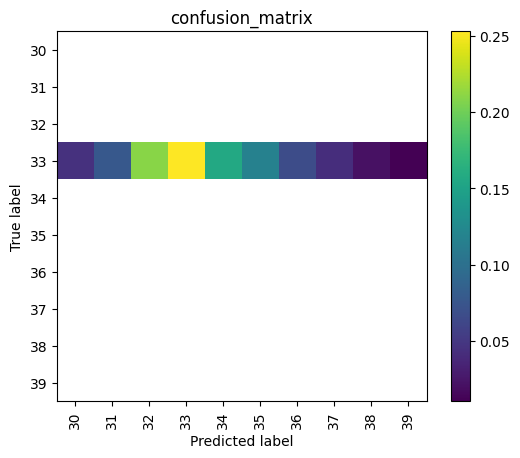

In [23]:
plot_confusion_matrix(a,range(30,40),"yaw_confusion_matrix")

C:\Users\Martin\AppData\Local\Temp\ipykernel_4568\1899464866.py:31: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化


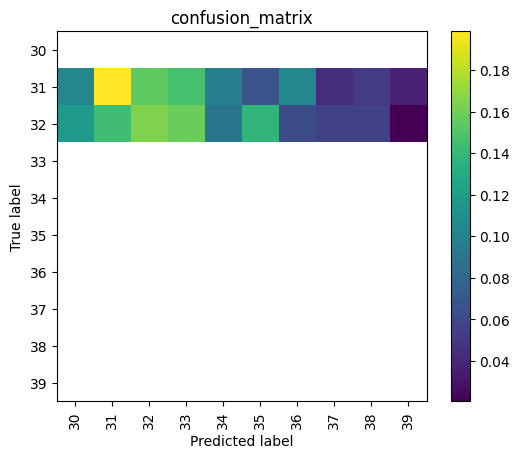

In [25]:
plot_confusion_matrix(b,range(30,40),"pitch_confusion_matrix")

C:\Users\Martin\AppData\Local\Temp\ipykernel_4568\1899464866.py:31: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化


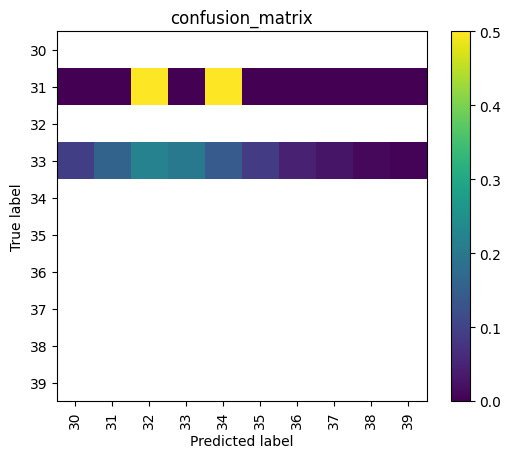

In [26]:
plot_confusion_matrix(c,range(30,40),"row_confusion_matrix")

# 9 Conclusions
这次实验，我为了解决这个棘手的regression problem，参考文献的思路，将连续值离散化，计算期望又得到了连续值，很巧妙地结合了起来，而且在评估性能上，也使用了confusion matrix 来检测。
这次实验的创新点有：1.对label做了处理，使之离散化，从而更好的训练模型；2.对三个维度的数值其实上是单独预测的，通过resnet提取图片特征，再将特征进入不同的全连接神经网络，在实验过程中，通过这种开叉式的网络结构，比一同预测三个值的网络结构有更好的性能。3.对loss function的处理也很微妙，采取两个数值一同优化，一个是离散的label，我选择了交叉熵函数，另一个是连续的lapel，通过计算预测的离散label的期望得到，与真实的连续label计算MSE，两个损失函数加在一起才是要优化的总的损失函数，这种方法在文献中得到实验，能有效提升模型精准度。

